# Quantile Regression Demo

#### Import Statements

In [1]:
import sys
sys.path.append("../../")

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
from uq360.algorithms.quantile_regression import QuantileRegression
from uq360.metrics import picp, mpiw

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

#### Load Boston Housing Prices Dataset

In [6]:
house_prices_dataset = datasets.load_boston()
house_prices_df = pd.DataFrame(house_prices_dataset['data'])
house_prices_df.columns = house_prices_dataset['feature_names']

all_features = ['RM','CRIM','PTRATIO', 'DIS']
X = house_prices_df[all_features].values
y = house_prices_dataset['target']

#### Train test split of the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Training data')

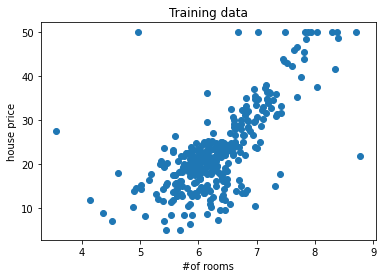

In [8]:
plt.scatter(X_train[:,0], y_train)
plt.xlabel('#of rooms')
plt.ylabel('house price')
plt.title('Training data')

In [9]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

### Train Quantile Regression

In [10]:
config = {
    "alpha":0.95,
    "n_estimators":20,
    "max_depth":3,
    "learning_rate":0.1,
    "min_samples_leaf":20,
    "min_samples_split":20
}

uq_model = QuantileRegression(model_type='gbr', config=config)

In [11]:
uq_model = uq_model.fit(X_train, y_train.squeeze())

In [12]:
y_mean, y_lower, y_upper = uq_model.predict(X_test)
y_mean, y_lower, y_upper = scaler_y.inverse_transform(y_mean), scaler_y.inverse_transform(y_lower), scaler_y.inverse_transform(y_upper)

In [13]:
pred_dict = {'rooms': scaler_X.inverse_transform(X_test)[:,0],
             'y': y_test,
             'y_mean': y_mean,
             'y_upper': y_upper,
             'y_lower': y_lower
            }

pred_df = pd.DataFrame(data=pred_dict)

pred_df_sorted = pred_df.sort_values(by='rooms')

Text(0.5, 1.0, 'Test data PICP: 0.89 MPIW: 19.87')

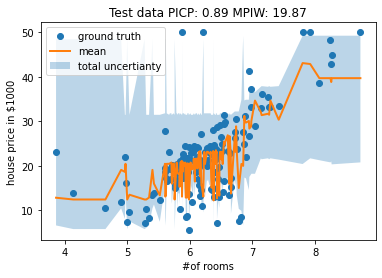

In [14]:
plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y'], 'o', label='ground truth')
plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y_mean'], '-', lw=2, label='mean')
plt.fill_between(pred_df_sorted['rooms'],
                         pred_df_sorted['y_upper'],
                         pred_df_sorted['y_lower'],
                         alpha=0.3, label='total uncertianty')
plt.legend()
plt.xlabel('#of rooms')
plt.ylabel('house price in $1000')
plt.title('Test data PICP: {:.2f} MPIW: {:.2f}'.format(
    picp(y_test, y_lower, y_upper),
    mpiw(y_lower, y_upper))      
         )

#### Let us now see the effect of increasing the number of estimators of the GBR on the prediction interval calibration.

In [15]:
num_estimators_arr = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
observed_alphas = np.zeros(len(num_estimators_arr))
observed_widths = np.zeros(len(num_estimators_arr))
rmses = np.zeros(len(num_estimators_arr))

for idx, num_estimators in enumerate(num_estimators_arr):
    
    config["n_estimators"] = num_estimators
    uq_model = QuantileRegression(model_type='gbr', config=config)
    uq_model = uq_model.fit(X_train, y_train.squeeze())
    y_mean, y_lower, y_upper = uq_model.predict(X_test)
    y_mean, y_lower, y_upper = scaler_y.inverse_transform(y_mean), scaler_y.inverse_transform(y_lower), scaler_y.inverse_transform(y_upper)
    observed_alphas[idx] = picp(y_test, y_lower, y_upper)
    observed_widths[idx] = mpiw(y_lower, y_upper)
    rmses[idx] = np.sqrt(mean_squared_error(y_test, y_mean))

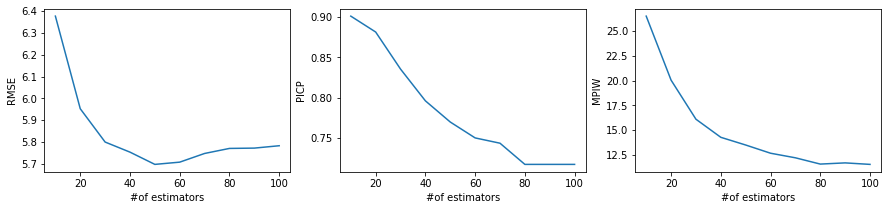

In [16]:
plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
plt.plot(num_estimators_arr, rmses)
plt.ylabel('RMSE')
plt.xlabel('#of estimators')
plt.subplot(1, 3, 2)
plt.plot(num_estimators_arr, observed_alphas)
plt.xlabel('#of estimators')
plt.ylabel('PICP')
plt.subplot(1, 3, 3)
plt.plot(num_estimators_arr, observed_widths)
plt.xlabel('#of estimators')
plt.ylabel('MPIW')
plt.show()

We can observe in the plots above that with an increase in the number of estimators used in the Gradiant boosted regression model, the RMSE and the average width of predictions (MPIW) reduce, but the calibration or coverage as measured by the PICP metric deteriorates. 